In [1]:
import sys
import healpy as hp
from astropy import units
import matplotlib.pyplot as plt
import numpy as np


sys.path.append('/Users/rebeccaceppas/Desktop/CHORD/spatial_matched_filter')

import maps
import mf_2d as m2
import mf_1d as m1

%load_ext autoreload
%autoreload 2

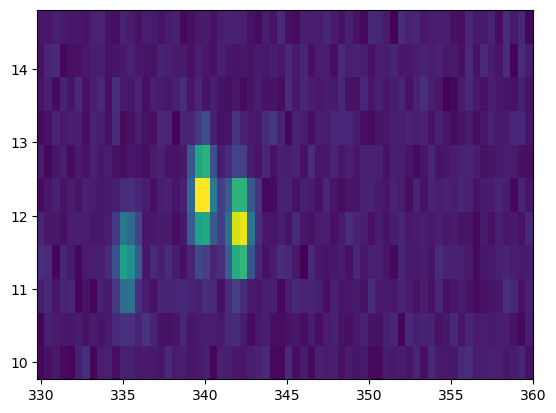

In [3]:
nside = 128
resolution = (hp.nside2resol(nside) * units.rad).to(units.deg).value

seed = 747

input_map = maps.InputMap(ra_max=360, ra_min=330, 
                          dec_max=15, dec_min=10,
                          nsources=3, 
                          resolution=resolution,
                          seed=seed)

map2d = input_map.get_2d_map(brightness=[1,1,0.5])

beam2d = input_map.get_2d_beam(maps.gaussian_beam, 1)

map_obs = input_map.observe(map2d, beam2d, add_noise=True, noise_std=3e-2)

plt.pcolor(input_map.ra, input_map.dec, map_obs)
plt.show()


In [55]:
## adding taper

import skimage
win = skimage.filters.window('tukey', map_obs.shape)
map2d_taper = map_obs * win

In [66]:
map1d_obs = input_map.get_1d_map(nside=nside, map_2d=map2d_taper)
beam1d = input_map.get_1d_map(nside, beam2d)


# 1D matched filter

In [67]:
def smooth_vector(vec, sig):

    n = len(vec)
    x = np.arange(n)
    x[n//2:] = x[n//2:] - n
    
    kernel=np.exp(-0.5*x**2/sig**2) #make a Gaussian kernel
    kernel=kernel/kernel.sum()

    vecft=np.fft.rfft(vec)
    kernelft=np.fft.rfft(kernel)
    vec_smooth=np.fft.irfft(vecft*kernelft) #convolve the data with the kernel
    
    return vec_smooth

def get_pspec(image, sigma):

    ps = np.abs(np.fft.fft(image))**2
    ps_smooth = smooth_vector(ps, sigma)

    return ps_smooth

In [68]:
Ninv = 1/get_pspec(map1d_obs, 10)

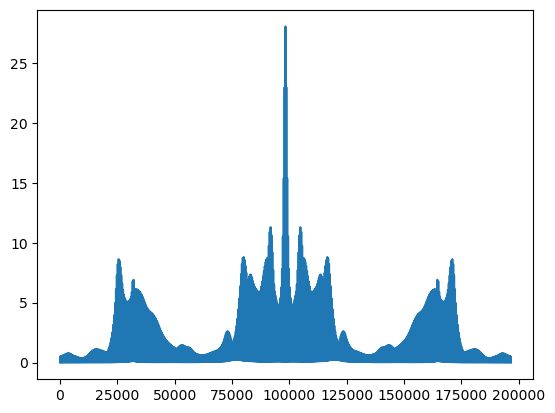

In [69]:
plt.plot(Ninv)

In [60]:
map_1d_white = np.fft.fft(map1d_obs) * np.sqrt(Ninv)
beam_1d_white = np.fft.fft(beam1d) * np.sqrt(Ninv)

denom = np.sqrt(beam_1d_white * beam_1d_white)

mf1d_denom = np.fft.fftshift(
    np.fft.ifft(
        np.fft.fftshift(
            map_1d_white * beam_1d_white / denom
    )))

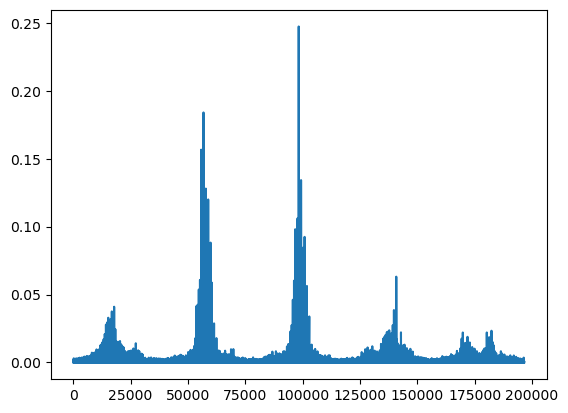

In [61]:
plt.plot(np.abs(mf1d_denom))
plt.show()


In [70]:
import mf_1d as m1
mf1d = m1.matched_filter1d(map1d_obs, beam1d, 4)

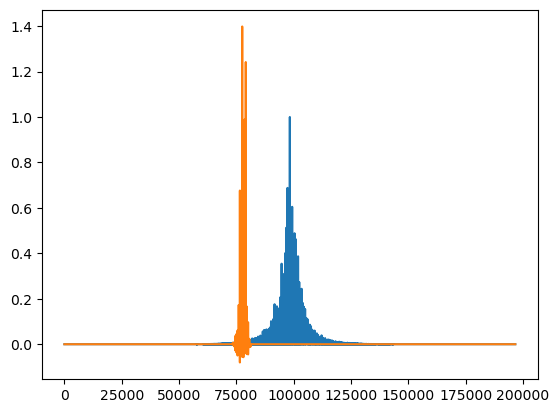

In [73]:
plt.plot(np.abs(mf1d)/np.max(mf1d))
plt.plot(map1d_obs)
